In [1]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
  !pip install adapt
  !pip install Tensorflow==2.15
else:
  import umap.umap_ as umap
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    #print('Number of MPS cards: ', torch.mps.device_count())
    #print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu124
CUDA device found.
Number of GPU cards:  1 
Which card GPU? NVIDIA GeForce RTX 3090
Total GPU memory 25.41 GB. Free GPU memory 25.02 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [ ]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

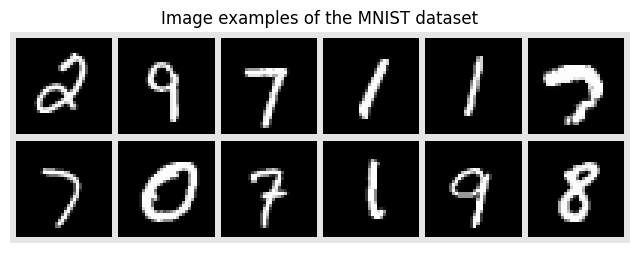

In [4]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [5]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


In [6]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [7]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [8]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


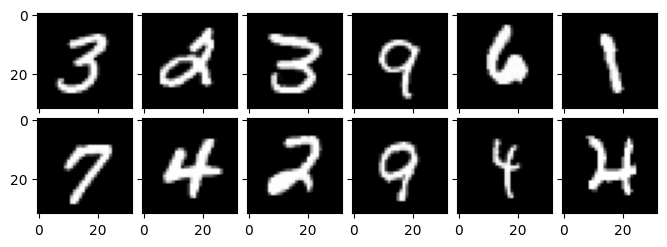

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [12]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


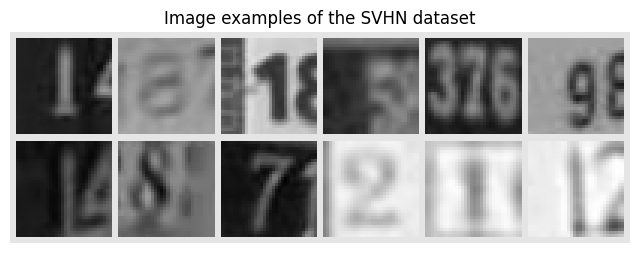

In [14]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [15]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [16]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [17]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

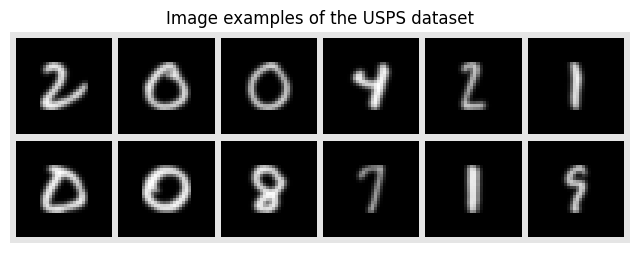

In [18]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [19]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [20]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [21]:
# MNIST
MNIST_Xtrain= MNIST_Xtrain_ima.reshape(MNIST_Xtrain_ima.shape[0], -1)
MNIST_Xtest= MNIST_Xtest_ima.reshape(MNIST_Xtest_ima.shape[0], -1)

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)


# USPS
USPS_Xtrain= USPS_Xtrain_ima.reshape(USPS_Xtrain_ima.shape[0], -1)
USPS_Xtest= USPS_Xtest_ima.reshape(USPS_Xtest_ima.shape[0], -1)

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain= SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0], -1)
SVHN_Xtest= SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0], -1)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [22]:

# Reduced MNIST
indices_mnist = np.random.choice(MNIST_Xtrain.shape[0], 1000, replace=False)
MNIST_Xtrain_res = MNIST_Xtrain[indices_mnist]
MNIST_ytrain_res = MNIST_ytrain[indices_mnist]

# Reduced USPS
indices_usps = np.random.choice(USPS_Xtrain.shape[0], 1000, replace=False)
USPS_Xtrain_res = USPS_Xtrain[indices_usps]
USPS_ytrain_res = USPS_ytrain[indices_usps]

# Reduced SVHN
indices_svhn = np.random.choice(SVHN_Xtrain.shape[0], 1000, replace=False)
SVHN_Xtrain_res = SVHN_Xtrain[indices_svhn]
SVHN_ytrain_res = SVHN_ytrain[indices_svhn]

# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]



In [23]:
xp = umap.UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

(3000, 2)


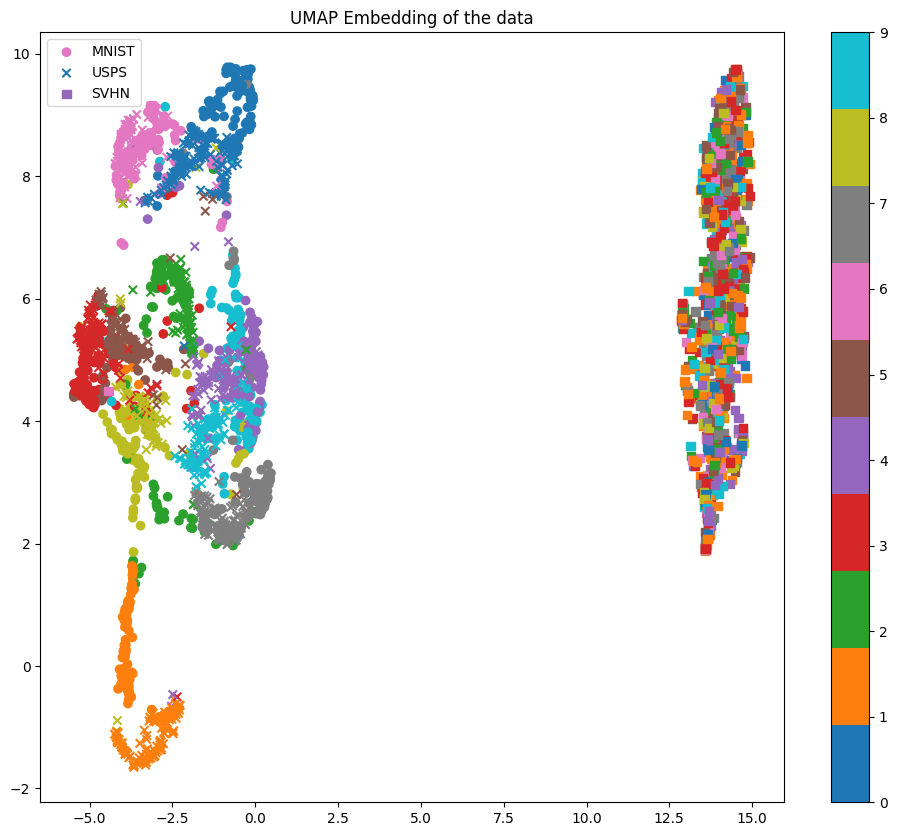

In [24]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

## ANSWER : 

When we apply the UMAP method we obtain a dimensionality reduction of the data and so we see that the two first datasets (MNIST and USPS) are close to each other whereas the SVHN form an other cluster shifted on the side. This reflects the diffrences on visual aspect of the data from each Dataset, indeed for the first two datasets the semantique representation of the numbers are close while SVHN data is more complex.

Since we notice that datasets form distinct clusters we can conclude that a domain gap exists between SVHN and the two others and so domain adaptation might be needed to reduce this gap.


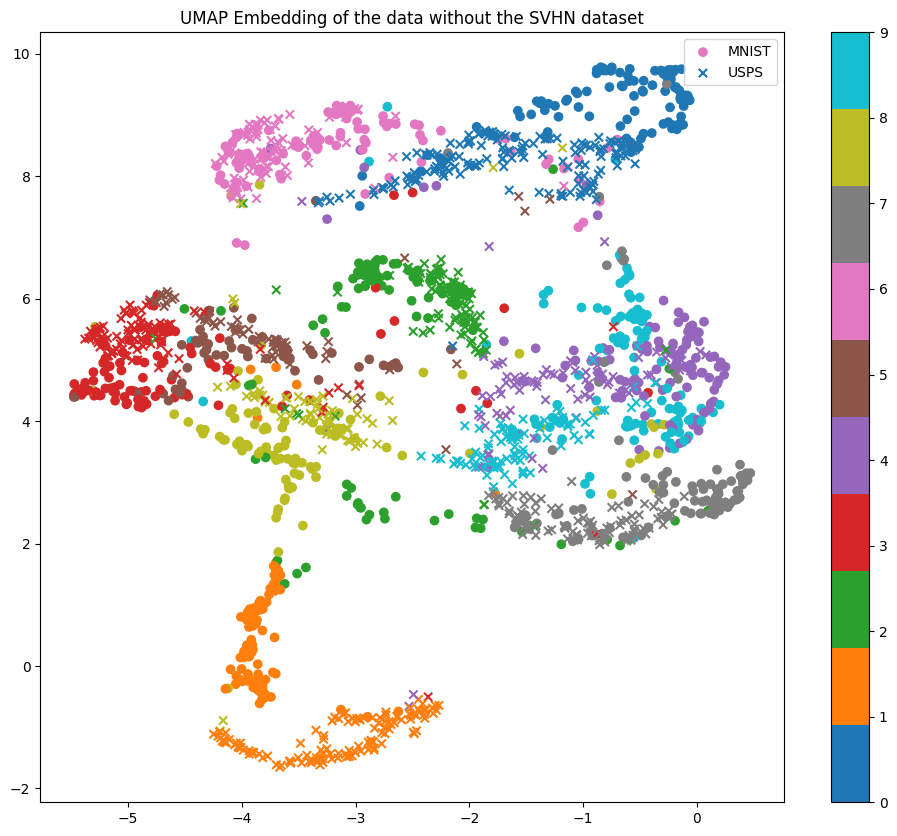

In [25]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
# plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data without the SVHN dataset')
plt.show()

**Question**: Can you see a domain shift between the datasets ?

**Asswer** : A Priori, we see that there isno particular domain shift since for the the two domains ( MNIST and USPS) the cluster are at the same place of the 2D space.  But if we look in detail we notice a slight decallage of the two points distributions which is explained by the fact that the source of the data is not the same.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [26]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 21.9 s, sys: 82.7 ms, total: 22 s
Wall time: 15.5 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


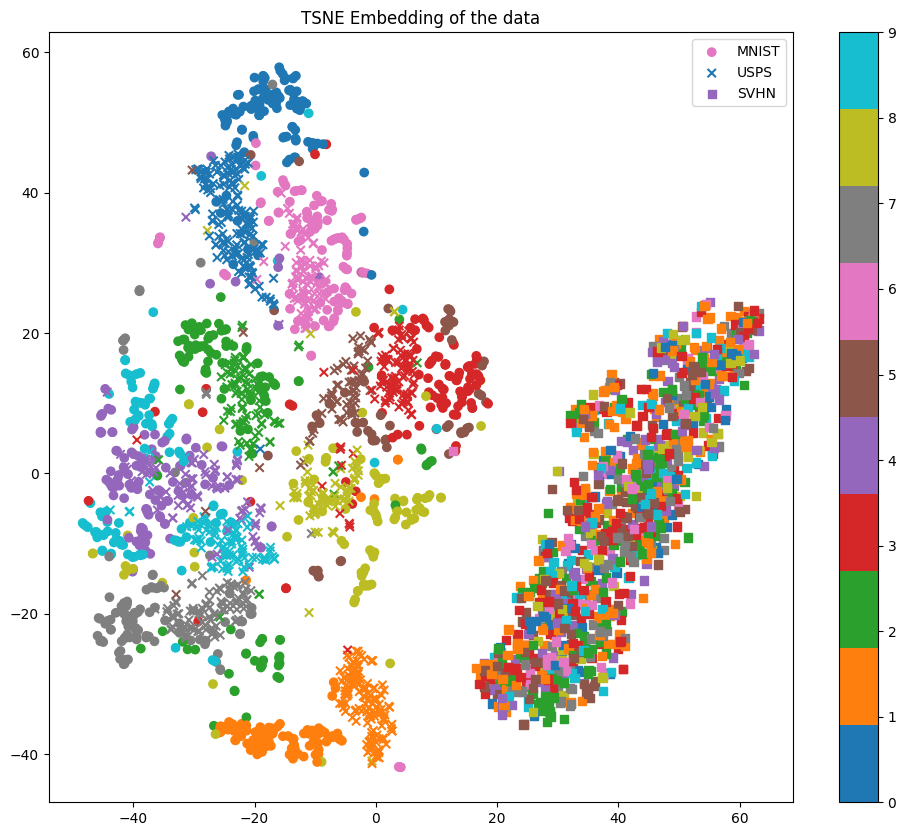

In [27]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

**ANSWER** : We confirm that there is domain shift between MNIST (or USPS) and SVHN data that we clearly notice. When we look closer, for the other two datases MNIST and USPS the representation induced by the method T-SNE separates the data in a diffrent way than the previous method and we still observe a little domain shift.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

In [28]:
### We analyse the dataset SVHN wich is separate from the two others : 

umap_SVHN = umap.UMAP().fit_transform(SVHN_Xtrain_res) # this should take ~50sec

nSVHN=SVHN_Xtrain_res.shape[0]
print(umap_SVHN.shape)


(1000, 2)


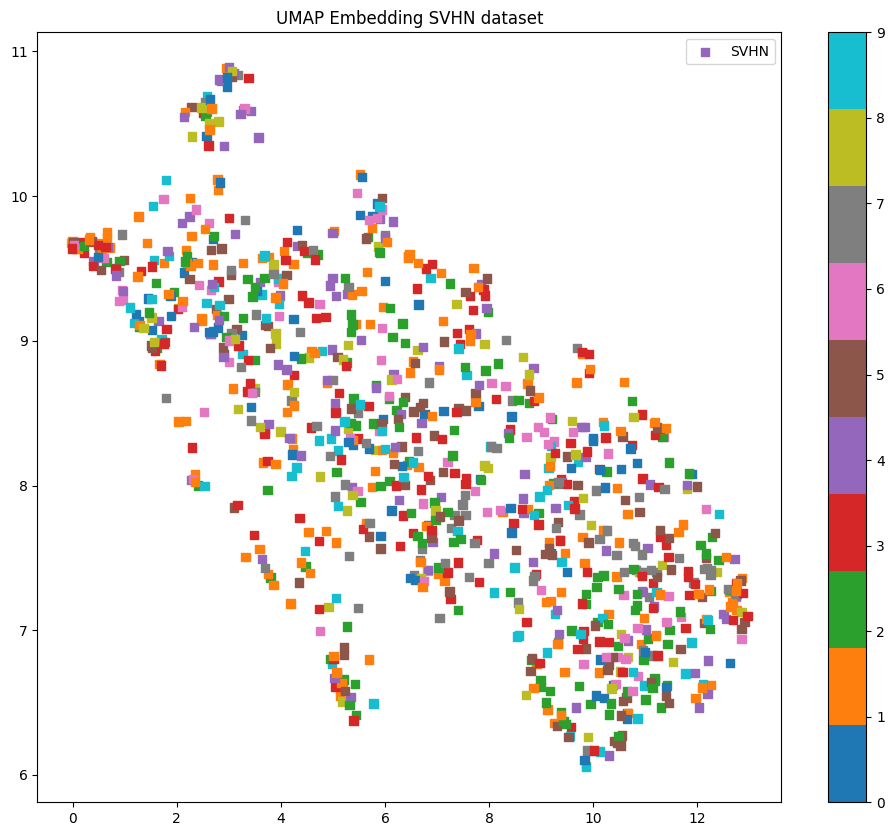

In [29]:

xpSVHN=umap_SVHN

plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding SVHN dataset')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?
Hint: think about the input space of UMAP...

**ANSWER** : The data is not cleatly clustered as the two others. In fact for me SVHN does not cluster as clearly as MNIST with umap because its input space is more complex( Google maps images have diverse backgrounds, varying digit sizes, different lighting conditions etc..). It is not the case for MNIST, which consists of simple, centered, grayscale handwritten digits. 

SVHN images contain variations and UMAP struggle to find clear structures in the data because of this data variation. Since UMAP relies on distances in the input space, the increased variability in SVHN leads to more dispersed and less distinct clusters compared to the others datasets.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [30]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [31]:
from sklearn.decomposition import PCA

def SA(XTrainS,XTestS,XTrainT,XTestT,d=10):
  """
  As in the lecture slides the Subspace Alignment function take in inputs : 
  XTrainS : Input training source data
  XTestS : Input test source data
  XTrainT : Input training target data
  XTestT : Input test target data 
  d : number of PCA components

  Output
  XTrainSp ,XTestSp ,XTrainTp ,XTestTp
  """

  # PCA on source and target data
  pca_source = PCA(n_components = d)
  pca_target = PCA(n_components = d)
  
  US = pca_source.fit(XTrainS).components_.T  # Source eigenvectors
  UT = pca_target.fit(XTrainT).components_.T  # Target eigenvectors
  
  # transformation matrix M to align US to UT
  M_star = np.dot(US.T, UT)
  
  # Projection source data onto US and apply transformation
  XTrainSp = np.dot(np.dot(XTrainS, US), M_star)
  XTestSp  = np.dot(np.dot(XTestS, US), M_star)
  
  # Projection target data onto UT
  XTrainTp = np.dot(XTrainT, UT) 
  XTestTp  = np.dot(XTestT, UT)


  return XTrainSp,XTestSp,XTrainTp,XTestTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Train of the classifier on source domain and evaluating on target domain
clf = SVC(kernel='linear')
clf.fit(XtrainS, ytrainS)
yPredT = clf.predict(XtestT)
accuracy = accuracy_score(ytestT, yPredT)
print(f"Classifier accuracy on target domain (no adaptation): {accuracy:.4f}")

    

Classifier accuracy on target domain (no adaptation): 0.5929


In [35]:
XTrainSp,XTestSp,XTrainTp,XTestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=20)

clf = SVC(kernel='linear')
clf.fit(XTrainSp, ytrainS)
yPredT_adapt = clf.predict(XTestTp)
accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
print(f"Classifier accuracy on target domain (with SA adaptation): {accuracy_adapt:.4f}")

Classifier accuracy on target domain (with SA adaptation): 0.6557


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

Classifier accuracy with PCA and d = 5 : 0.3473
Classifier accuracy with SA adaptation and d = 5: 0.1001
Classifier accuracy with PCA and d = 10 : 0.5042
Classifier accuracy with SA adaptation and d = 10: 0.4584
Classifier accuracy with PCA and d = 20 : 0.5745
Classifier accuracy with SA adaptation and d = 20: 0.6527
Classifier accuracy with PCA and d = 30 : 0.5909
Classifier accuracy with SA adaptation and d = 30: 0.6477
Classifier accuracy with PCA and d = 40 : 0.6039
Classifier accuracy with SA adaptation and d = 40: 0.6403


Text(0.5, 1.0, 'Accuracy of the classifier with PCA and SA adaptation')

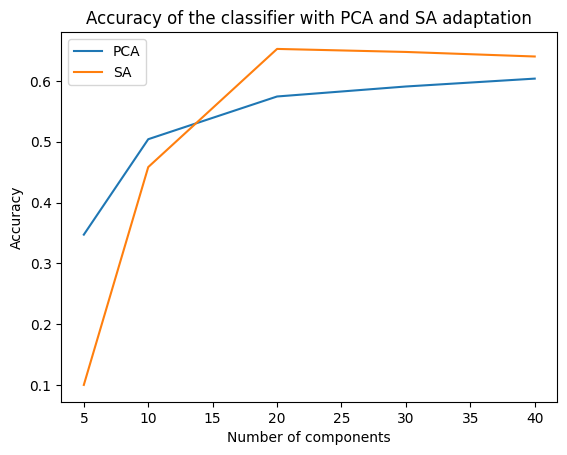

In [36]:
def PCA_Projection_Source(XTrainS, XTestS, XTrainT, XTestT, d=10):
    """
    Single PCA projection using only source training data.
    """
    pca_source = PCA(n_components=d)
    pca_source.fit(XTrainS)  # Fit only on source training
    
    # Project all data using the source PCA components
    XTrainSp = pca_source.transform(XTrainS)
    XTestSp  = pca_source.transform(XTestS)
    XTrainTp = pca_source.transform(XTrainT)
    XTestTp  = pca_source.transform(XTestT)
    
    return XTrainSp, XTestSp, XTrainTp, XTestTp

d_values = [5, 10, 20, 30, 40] 
d_accuracy_PCA = []
d_accuracy_SA = []


for d in d_values : 
    XTrainSp,XTestSp,XTrainTp,XTestTp = PCA_Projection_Source(XtrainS,XtestS,XtrainT,XtestT,d)

    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"Classifier accuracy with PCA and d = {d} : {accuracy_adapt:.4f}")
    d_accuracy_PCA.append(accuracy_adapt)

    XTrainSp,XTestSp,XTrainTp,XTestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d)

    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"Classifier accuracy with SA adaptation and d = {d}: {accuracy_adapt:.4f}")
    d_accuracy_SA.append(accuracy_adapt)


    

plt.plot(d_values, d_accuracy_PCA, label='PCA')
plt.plot(d_values, d_accuracy_SA, label='SA')
plt.xlabel('Number of components')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy of the classifier with PCA and SA adaptation')

**Answer : We try diffrent values of d and we see that more d is big the accuracy is high. Because reducing too brutaly teh dimension can cause a loss of information which is bad for prediction.**

**We also observe on the plot below that we need less dimension to reach reasonable accuracy when we do the PCA.**

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

#### **Variation of d and test ML methods and test simple deep learning architecture :**

In [39]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier


In [40]:
d_values = [10, 20, 30, 40, 50]

for d in d_values:
    print(f"####  Test avec d = {d} ####")
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)
    
    # SVM
    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"\n Linear SVM accuracy on target domain (d={d}): {accuracy_adapt:.4f}")
    
    # Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100)
    clf_rf.fit(XTrainSp, ytrainS)
    yPredT_rf = clf_rf.predict(XTestTp)
    accuracy_rf = accuracy_score(ytestT, yPredT_rf)
    print(f"\n Random Forest accuracy on target domain (d={d}): {accuracy_rf:.4f}")
    
    # XGBoost
    clf_xgb = XGBClassifier(n_estimators=100)
    clf_xgb.fit(XTrainSp, ytrainS)
    yPredT_xgb = clf_xgb.predict(XTestTp)
    accuracy_xgb = accuracy_score(ytestT, yPredT_xgb)
    print(f"\n XGBoost accuracy on target domain (d={d}): {accuracy_xgb:.4f}")

    # Neural Network
    clf_nn = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100)
    clf_nn.fit(XTrainSp, ytrainS)
    yPredT_nn = clf_nn.predict(XTestTp)
    accuracy_nn = accuracy_score(ytestT, yPredT_nn)
    print(f"\n Neural Network accuracy on target domain (d={d}): {accuracy_nn:.4f}")



####  Test avec d = 10 ####

 Linear SVM accuracy on target domain (d=10): 0.4589

 Random Forest accuracy on target domain (d=10): 0.5501

 XGBoost accuracy on target domain (d=10): 0.5580


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=10): 0.5964
####  Test avec d = 20 ####

 Linear SVM accuracy on target domain (d=20): 0.6547

 Random Forest accuracy on target domain (d=20): 0.6253

 XGBoost accuracy on target domain (d=20): 0.6158


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=20): 0.6467
####  Test avec d = 30 ####

 Linear SVM accuracy on target domain (d=30): 0.6512

 Random Forest accuracy on target domain (d=30): 0.6044

 XGBoost accuracy on target domain (d=30): 0.6139


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=30): 0.6477
####  Test avec d = 40 ####

 Linear SVM accuracy on target domain (d=40): 0.6368

 Random Forest accuracy on target domain (d=40): 0.5765

 XGBoost accuracy on target domain (d=40): 0.6064


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=40): 0.6801
####  Test avec d = 50 ####

 Linear SVM accuracy on target domain (d=50): 0.6547

 Random Forest accuracy on target domain (d=50): 0.5695

 XGBoost accuracy on target domain (d=50): 0.5909

 Neural Network accuracy on target domain (d=50): 0.6971


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


**Observations : We see that the deep learning model is the best one, probably because of his capacity to model complex data. Also in these tests the linear classifier performs better than the two others ones, we see that the accuracy increase with d at the begening.**

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


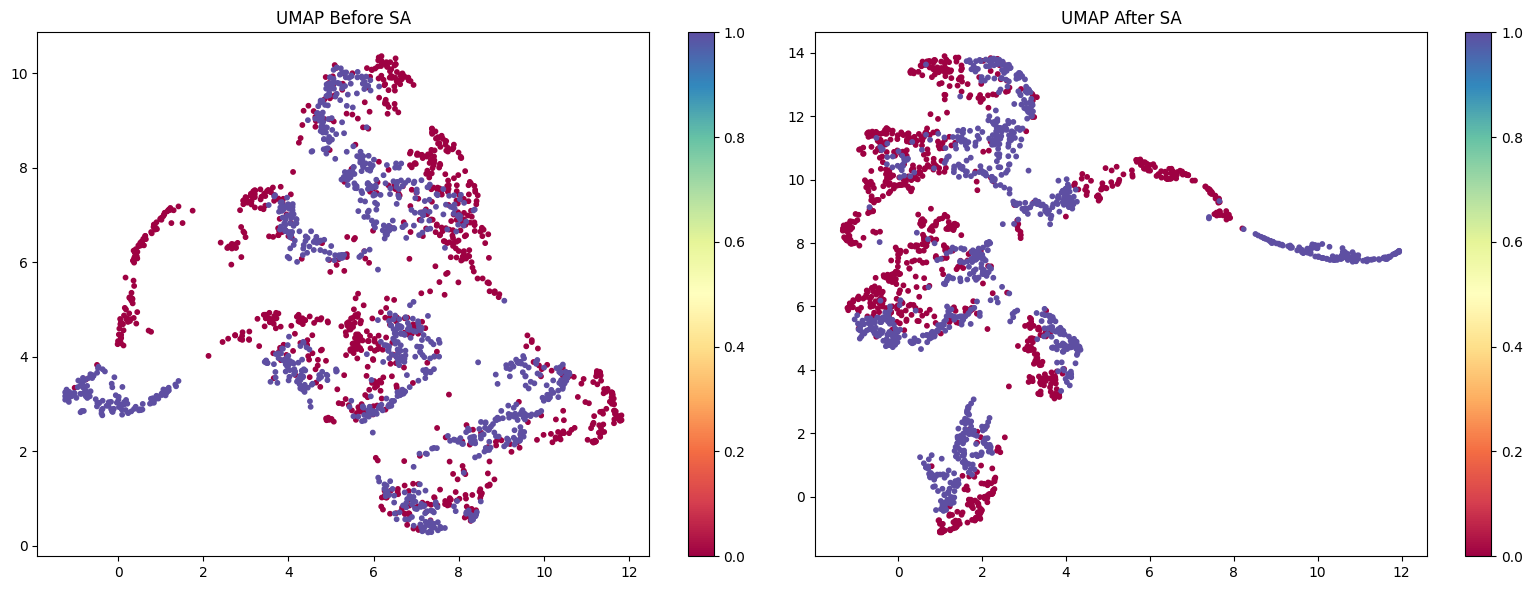

In [43]:
d = 20  
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

X_before = np.vstack((XtrainS, XtrainT)) 
X_after = np.vstack((XTrainSp, XTrainTp)) 

labels_before = np.hstack((np.zeros(XtrainS.shape[0]), np.ones(XtrainT.shape[0])))
labels_after = np.hstack((np.zeros(XTrainSp.shape[0]), np.ones(XTrainTp.shape[0])))

# UMAP plot
def plot_umap(X, labels, title, ax):
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X)
    
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=10)
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_umap(X_before, labels_before, "UMAP Before SA", ax1)

plot_umap(X_after, labels_after, "UMAP After SA", ax2)

plt.tight_layout()
plt.show()

**Obsrevation** : We observe a better separation of points in the space of reducing dimension after using SA adaptation. 

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

## **Source MNIST, Target: SVHN**


Classifier accuracy with PCA and d = 5 : 0.1063
Classifier accuracy with SA adaptation and d = 5: 0.0866
Classifier accuracy with PCA and d = 10 : 0.1140
Classifier accuracy with SA adaptation and d = 10: 0.1417
Classifier accuracy with PCA and d = 20 : 0.1293
Classifier accuracy with SA adaptation and d = 20: 0.1018
Classifier accuracy with PCA and d = 30 : 0.1564
Classifier accuracy with SA adaptation and d = 30: 0.1042
Classifier accuracy with PCA and d = 40 : 0.1524
Classifier accuracy with SA adaptation and d = 40: 0.1150
####  Test avec d = 10 ####

 Linear SVM accuracy on target domain (d=10): 0.1423

 Random Forest accuracy on target domain (d=10): 0.1145

 XGBoost accuracy on target domain (d=10): 0.1196


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=10): 0.1781
####  Test avec d = 20 ####

 Linear SVM accuracy on target domain (d=20): 0.1012

 Random Forest accuracy on target domain (d=20): 0.1167

 XGBoost accuracy on target domain (d=20): 0.1133


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=20): 0.0912
####  Test avec d = 30 ####

 Linear SVM accuracy on target domain (d=30): 0.1045

 Random Forest accuracy on target domain (d=30): 0.1200

 XGBoost accuracy on target domain (d=30): 0.1209


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=30): 0.1694
####  Test avec d = 40 ####

 Linear SVM accuracy on target domain (d=40): 0.1174

 Random Forest accuracy on target domain (d=40): 0.1245

 XGBoost accuracy on target domain (d=40): 0.1302


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=40): 0.0972
####  Test avec d = 50 ####

 Linear SVM accuracy on target domain (d=50): 0.1153

 Random Forest accuracy on target domain (d=50): 0.1408

 XGBoost accuracy on target domain (d=50): 0.1354


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



 Neural Network accuracy on target domain (d=50): 0.1410


/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/users/eleves-a/2024/amine.razig/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


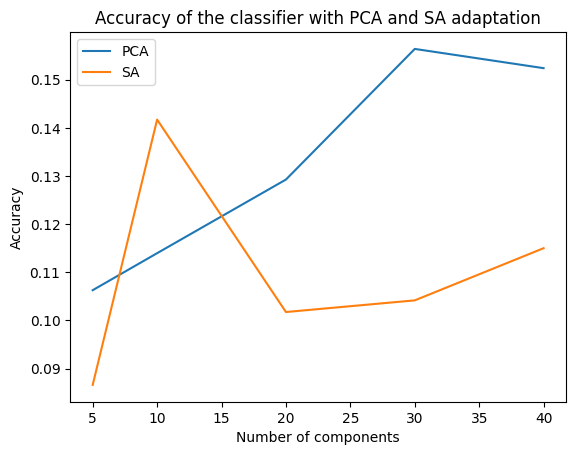

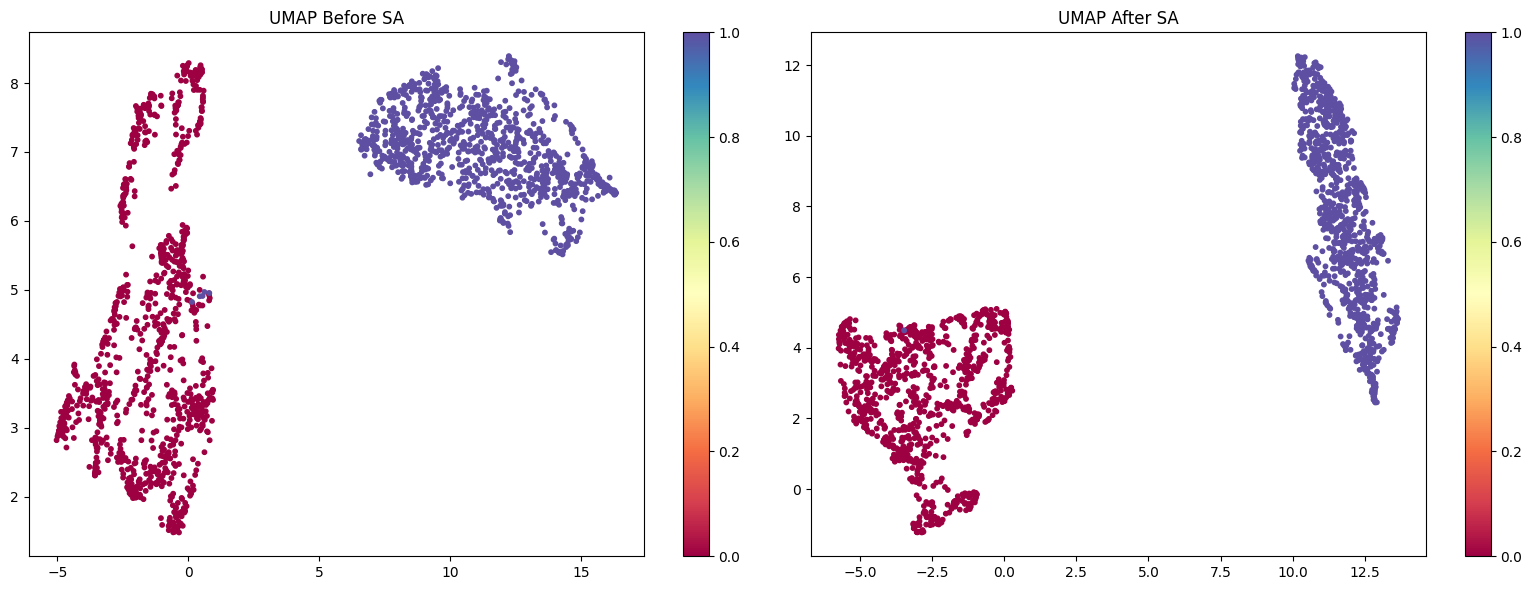

In [45]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

d_values = [5, 10, 20, 30, 40] 
d_accuracy_PCA = []
d_accuracy_SA = []


for d in d_values : 
    XTrainSp,XTestSp,XTrainTp,XTestTp = PCA_Projection_Source(XtrainS,XtestS,XtrainT,XtestT,d)

    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"Classifier accuracy with PCA and d = {d} : {accuracy_adapt:.4f}")
    d_accuracy_PCA.append(accuracy_adapt)

    XTrainSp,XTestSp,XTrainTp,XTestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d)

    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"Classifier accuracy with SA adaptation and d = {d}: {accuracy_adapt:.4f}")
    d_accuracy_SA.append(accuracy_adapt)


    

plt.plot(d_values, d_accuracy_PCA, label='PCA')
plt.plot(d_values, d_accuracy_SA, label='SA')
plt.xlabel('Number of components')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy of the classifier with PCA and SA adaptation')

d_values = [10, 20, 30, 40, 50]

for d in d_values:
    print(f"####  Test avec d = {d} ####")
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)
    
    # SVM
    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, ytrainS)
    yPredT_adapt = clf.predict(XTestTp)
    accuracy_adapt = accuracy_score(ytestT, yPredT_adapt)
    print(f"\n Linear SVM accuracy on target domain (d={d}): {accuracy_adapt:.4f}")
    
    # Random Forest
    clf_rf = RandomForestClassifier(n_estimators=100)
    clf_rf.fit(XTrainSp, ytrainS)
    yPredT_rf = clf_rf.predict(XTestTp)
    accuracy_rf = accuracy_score(ytestT, yPredT_rf)
    print(f"\n Random Forest accuracy on target domain (d={d}): {accuracy_rf:.4f}")
    
    # XGBoost
    clf_xgb = XGBClassifier(n_estimators=100)
    clf_xgb.fit(XTrainSp, ytrainS)
    yPredT_xgb = clf_xgb.predict(XTestTp)
    accuracy_xgb = accuracy_score(ytestT, yPredT_xgb)
    print(f"\n XGBoost accuracy on target domain (d={d}): {accuracy_xgb:.4f}")

    # Neural Network
    clf_nn = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100)
    clf_nn.fit(XTrainSp, ytrainS)
    yPredT_nn = clf_nn.predict(XTestTp)
    accuracy_nn = accuracy_score(ytestT, yPredT_nn)
    print(f"\n Neural Network accuracy on target domain (d={d}): {accuracy_nn:.4f}")

## BEFOR AND AFTER SA :

d = 20  
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=d)

X_before = np.vstack((XtrainS, XtrainT)) 
X_after = np.vstack((XTrainSp, XTrainTp)) 

labels_before = np.hstack((np.zeros(XtrainS.shape[0]), np.ones(XtrainT.shape[0])))
labels_after = np.hstack((np.zeros(XTrainSp.shape[0]), np.ones(XTrainTp.shape[0])))

# UMAP plot
def plot_umap(X, labels, title, ax):
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X)
    
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=10)
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_umap(X_before, labels_before, "UMAP Before SA", ax1)

plot_umap(X_after, labels_after, "UMAP After SA", ax2)

plt.tight_layout()
plt.show()

**Answer : When using MNIST as the source domain and SVHN as the target domain, there is a clear and significant domain gap between the two datasets ( we notoce it at the begin of the lab). This  difference explains why applying subspace alignment does not provide meaningful benefits in this scenario and why the resulting predictions are of significantly lower quality. Also we can remark the fact that SA assumes a linear relationship between the source and target domains witch is not ncesserly the case**

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

**Answer** : If we decrease the number of labeled samples, the model has less information to learn from the source domain. This can leads to bad generalization to the target domain. Also it can increases the variance of the model predictions, because the model is not train enaught to generalize well. The result of the little experiment bellow is according to the theory.

In [47]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

sample_sizes = [100, 500, 1000, 5000]

results = {}
for size in sample_sizes:
    # Reduce the number of labeled samples
    X_trainS_reduced = XtrainS[:size]
    y_trainS_reduced = ytrainS[:size]
    
    XTrainSp, _, XTrainTp, XTestTp = SA(X_trainS_reduced, XtestS, XtrainT, XtestT, d=d)
    
    clf = SVC(kernel='linear')
    clf.fit(XTrainSp, y_trainS_reduced)
    
    y_pred = clf.predict(XTestTp)
    accuracy = accuracy_score(ytestT, y_pred)
    results[size] = accuracy

for size, accuracy in results.items():
    print(f"Labeled samples: {size}, Accuracy on target domain: {accuracy:.4f}")


Labeled samples: 100, Accuracy on target domain: 0.4903
Labeled samples: 500, Accuracy on target domain: 0.6308
Labeled samples: 1000, Accuracy on target domain: 0.6512
Labeled samples: 5000, Accuracy on target domain: 0.6547


**Optional**: You can test other methods using the `adapt`library. See `https://adapt-python.github.io/adapt/`. You will need Tensorflow==2.15

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

In [ ]:
from adapt.feature_based import MDD
model = MDD(encoder=XXXX,task=XXXXX,lambda_=0.1, gamma=4., Xt=XtrainT, metrics=["accuracy"], random_state=0)
model.fit(XtrainS, ytrainS, epochs=100, verbose=0)
model.score(XtrainS, ytrainS)


In [ ]:
from adapt.feature_based import DANN

model = DANN(XXXXXX)
model.fit(XXXXXX)
model.score(XXXXXXX)


**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...